[View in Colaboratory](https://colab.research.google.com/github/mingweihe/ImageNet/blob/master/prediction_on_colab_TODO.ipynb)

In [0]:
#------------------------------------------------
#    Training and Test data set preparation
#------------------------------------------------
# !rm -rf checkpoints && rm -rf *.zip
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from IPython.display import clear_output

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Downloading hafl trained model
local_download_path = os.path.expanduser('~')
file_list = drive.ListFile(
    {'q': "'1qJP7EQ19JWVg7nG7njpC2Of5Pb8WsSIN' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)

# !unzip /content/*.zip
# clear_output()

title: test.tar.gz, id: 17ZKh13biDYODOCQLjXmXJJikib2hLzEp
downloading to /root/test.tar.gz


In [1]:
!ls

adc.json  sample_data


In [0]:
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import time
import os

In [0]:
# Set parameters
chkp_dir = os.path.join('checkpoints', 'cnnGesture')
chkp_name = 'model'

In [0]:
# images plotting function
def plotImg(imgs, titles = None):
    fig = plt.figure()
    for i in range(len(imgs)):
        ax = fig.add_subplot(1, len(imgs), i + 1)
        if titles != None:
            ax.title.set_text(titles[i])
        plt.imshow(imgs[i])
        plt.axis('off')
    plt.show()

In [0]:
# restore checkpoint
sessRes = tf.Session()
saver = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver.restore(sessRes, tf.train.latest_checkpoint(chkp_dir))

INFO:tensorflow:Restoring parameters from checkpoints/cnnGesture/model


In [0]:
# variable and tensor initialization
img_holder = sessRes.graph.get_tensor_by_name('img_holder:0')
lbl_holder =sessRes.graph.get_tensor_by_name('lbl_holder:0')
loss=sessRes.graph.get_tensor_by_name('loss:0')
accuracy=tf.get_default_graph().get_tensor_by_name('accuracy:0')
optimizer=tf.get_default_graph().get_tensor_by_name('optimizer:0')
predict=tf.get_default_graph().get_tensor_by_name('prediction:0')
train = sessRes.graph.get_tensor_by_name('train_bool:0')
log_dir = sessRes.run('log_dir:0').decode('utf-8')
test_total = sessRes.run('test_total:0')
train_total = sessRes.run('train_total:0')
num_epochs = sessRes.run('num_epochs:0')
batch_size = sessRes.run('batch_size:0')
global_step = sessRes.run('global_step:0')
global_epoch = int(global_step*batch_size/train_total)
# # tensorboard
# summary_loss = tf.summary.scalar('loss', loss)
# summary_accuracy = tf.summary.scalar('accuracy', accuracy)
# merged_op = tf.summary.merge([summary_loss, summary_accuracy])
# # Create FileWriter
# file_writer = tf.summary.FileWriter(log_dir, graph=tf.get_default_graph())
print('number of epoch for each training:', num_epochs)
print('batch size of each step:', batch_size)
print('total test set:', test_total)
print('total train set:', train_total)
print('global steps:', global_step)
print('global epochs:', global_epoch)

number of epoch for each training: 10
batch size of each step: 10
total test set: 369
total train set: 15819
global steps: 47457
global epochs: 30


In [0]:
# session to exexute queuing
# restore checkpoint
sess4Q = tf.Session()
saver4Q = tf.train.import_meta_graph(os.path.join(chkp_dir, 'model.meta'))
saver4Q.restore(sess4Q, tf.train.latest_checkpoint(chkp_dir))
batchTrainData = sess4Q.graph.get_tensor_by_name('batchTrainData:0')
batchTrainLabel = sess4Q.graph.get_tensor_by_name('batchTrainData:1')
totalTestData = sess4Q.graph.get_tensor_by_name('totalTestData:0')
totalTestLabel = sess4Q.graph.get_tensor_by_name('totalTestData:1')
sess4Q.run(tf.local_variables_initializer())
coord=tf.train.Coordinator()
threads=tf.train.start_queue_runners(sess=sess4Q,coord=coord)

INFO:tensorflow:Restoring parameters from checkpoints/cnnGesture/model


In [0]:
try:
    test_images,test_labels = sess4Q.run([totalTestData, totalTestLabel])
    batch_i = 1
    total_batch = 0
    local_epoch = 1
    start_time = time.time()
    while not coord.should_stop():
        imgs, labels = sess4Q.run([batchTrainData,batchTrainLabel])
        sessRes.run(optimizer, feed_dict={img_holder:imgs,lbl_holder:labels,train: True})
#         loss_val, accuracy_val, summary = sessRes.run([loss, accuracy, merged_op],feed_dict={img_holder:imgs,lbl_holder:labels,train: False})
#         # Print the summary data
#         file_writer.add_summary(summary)
        if batch_i % 100 == 0:
            loss_val, accuracy_val = sessRes.run([loss, accuracy],feed_dict={img_holder:imgs,lbl_holder:labels,train: False})
            test_accuracy = sessRes.run(accuracy, feed_dict={img_holder:test_images[169:269],lbl_holder:test_labels[169:269],train: False})
#             file_writer.flush()
            duration = time.time() - start_time
            print('epoch:', str(local_epoch)+ '/' +str(num_epochs), 'batch:', batch_i, 'loss:', 
                  loss_val, 'cur_accuracy:', accuracy_val, 'test_accuracy:', test_accuracy, 'duration: %.3fs' % duration)
            start_time = time.time()
        batch_i += 1
        total_batch += batch_size
        if total_batch >= train_total:
            local_epoch += 1
            total_batch = 0
            batch_i = 1
except tf.errors.OutOfRangeError:
    print('Done.')
except Exception as e:
    coord.request_stop(e)
finally:
    coord.request_stop()
coord.join(threads)
sess4Q.close()
# save training result
saver.save(sessRes, os.path.join(chkp_dir, chkp_name))

epoch: 1/10 batch: 100 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.69 duration: 21.391s
epoch: 1/10 batch: 200 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.72 duration: 16.119s
epoch: 1/10 batch: 300 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.69 duration: 16.129s
epoch: 1/10 batch: 400 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.64 duration: 16.070s
epoch: 1/10 batch: 500 loss: 3.006787 cur_accuracy: 0.9 test_accuracy: 0.67 duration: 16.140s
epoch: 1/10 batch: 600 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.61 duration: 16.116s
epoch: 1/10 batch: 700 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.61 duration: 16.110s
epoch: 1/10 batch: 800 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.57 duration: 16.119s
epoch: 1/10 batch: 900 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.73 duration: 16.195s
epoch: 1/10 batch: 1000 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.7 duration: 16.112s
epoch: 1/10 batch: 1100 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.61 duration: 16.112s
epoch: 1/10 bat

epoch: 4/10 batch: 200 loss: 4.5195417 cur_accuracy: 0.9 test_accuracy: 0.65 duration: 16.044s
epoch: 4/10 batch: 300 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.71 duration: 16.044s
epoch: 4/10 batch: 400 loss: 15.781122 cur_accuracy: 0.9 test_accuracy: 0.67 duration: 16.042s
epoch: 4/10 batch: 500 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.73 duration: 16.065s
epoch: 4/10 batch: 600 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.62 duration: 16.093s
epoch: 4/10 batch: 700 loss: 6.079655e-07 cur_accuracy: 1.0 test_accuracy: 0.64 duration: 16.055s
epoch: 4/10 batch: 800 loss: 2.4912646 cur_accuracy: 0.9 test_accuracy: 0.67 duration: 16.030s
epoch: 4/10 batch: 900 loss: 0.0002536246 cur_accuracy: 1.0 test_accuracy: 0.69 duration: 16.039s
epoch: 4/10 batch: 1000 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.68 duration: 16.018s
epoch: 4/10 batch: 1100 loss: 73.440125 cur_accuracy: 0.7 test_accuracy: 0.59 duration: 16.069s
epoch: 4/10 batch: 1200 loss: 15.445734 cur_accuracy: 0.7 test_acc

epoch: 7/10 batch: 200 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.57 duration: 16.070s
epoch: 7/10 batch: 300 loss: 2.8610188e-07 cur_accuracy: 1.0 test_accuracy: 0.63 duration: 16.051s
epoch: 7/10 batch: 400 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.62 duration: 16.013s
epoch: 7/10 batch: 500 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.69 duration: 16.027s
epoch: 7/10 batch: 600 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.77 duration: 16.031s
epoch: 7/10 batch: 700 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.57 duration: 16.047s
epoch: 7/10 batch: 800 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.68 duration: 16.044s
epoch: 7/10 batch: 900 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.68 duration: 16.054s
epoch: 7/10 batch: 1000 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.64 duration: 16.051s
epoch: 7/10 batch: 1100 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.69 duration: 16.074s
epoch: 7/10 batch: 1200 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.55 duration: 16.112s
epoch: 7

epoch: 10/10 batch: 300 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.63 duration: 16.023s
epoch: 10/10 batch: 400 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.7 duration: 16.029s
epoch: 10/10 batch: 500 loss: 15.7164135 cur_accuracy: 0.9 test_accuracy: 0.69 duration: 16.061s
epoch: 10/10 batch: 600 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.67 duration: 16.096s
epoch: 10/10 batch: 700 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.63 duration: 16.066s
epoch: 10/10 batch: 800 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.65 duration: 16.082s
epoch: 10/10 batch: 900 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.7 duration: 15.992s
epoch: 10/10 batch: 1000 loss: 3.3480408 cur_accuracy: 0.9 test_accuracy: 0.79 duration: 16.016s
epoch: 10/10 batch: 1100 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.68 duration: 16.090s
epoch: 10/10 batch: 1200 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.71 duration: 16.035s
epoch: 10/10 batch: 1300 loss: 0.0 cur_accuracy: 1.0 test_accuracy: 0.69 duration: 16.

'checkpoints/cnnGesture/model'

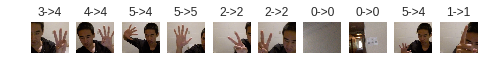

Accuracy: 0.7


In [0]:
begin = random.randrange(0, test_total-10)
end = begin + 10
res, accuracy_val = sessRes.run([predict, accuracy], feed_dict = {img_holder: test_images[begin:end], lbl_holder:test_labels[begin:end], train: False})
titles = [str(np.argmax(test_labels[i])) + '->' + str(res[i-begin]) for i in range(begin, end)] 
plotImg(test_images[begin:end], titles)
print('Accuracy:', accuracy_val)

In [0]:
sessRes.close()

In [0]:
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [0]:
#------------------------------------------------
#    Replace google drive trained model with new one
#------------------------------------------------
!rm -rf Hybrid7.zip
!zip -r Hybrid7.zip checkpoints
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_list = drive.ListFile(
    {'q': "'19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3' in parents"}).GetList()

for f in file_list:
  # delete old one
  fname = f['title']
  print('Deleting', fname)
  f.Delete()
file_metadata = {'title': 'Hybrid7.zip', "parents": [{"id": '19lVhhib3mhWMW_eQsFFoOQLVsmfN6SB3', "kind": "drive#childList"}]}
# Create & upload a file.
uploaded = drive.CreateFile(file_metadata)
uploaded.SetContentFile('Hybrid7.zip')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

  adding: checkpoints/ (stored 0%)
  adding: checkpoints/cnnGesture/ (stored 0%)
  adding: checkpoints/cnnGesture/checkpoint (deflated 39%)
  adding: checkpoints/cnnGesture/model.data-00000-of-00001 (deflated 19%)
  adding: checkpoints/cnnGesture/model.index (deflated 50%)
  adding: checkpoints/cnnGesture/model.meta (deflated 90%)
Deleting Hybrid7.zip
Uploaded file with ID 193XclOXHlbRnU2E8EHlpXbmXcib4WRJg
